   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1         ₹349                 43%  

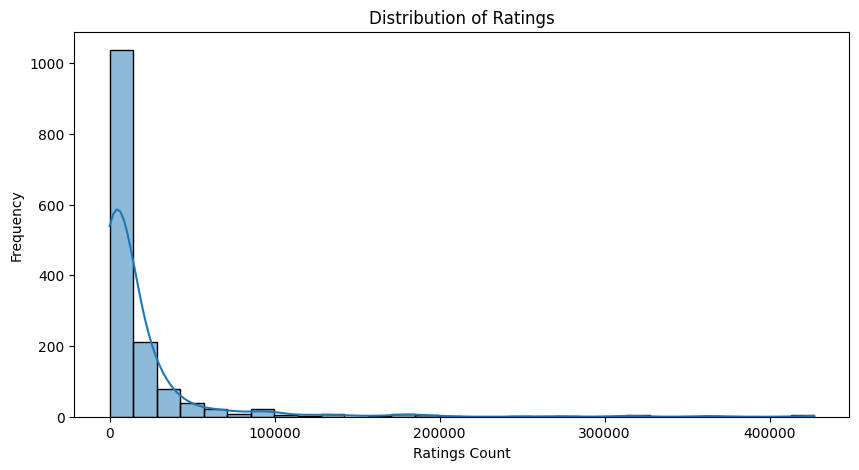


Correlation Between Discount Percentage & Rating Count:
                      discount_percentage  rating_count
discount_percentage             1.000000      0.011691
rating_count                    0.011691      1.000000


C:\Users\SHARON\AppData\Local\Temp\ipykernel_23116\1137631017.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_rated['product_name'], x=top_rated['rating_count'], palette="viridis")


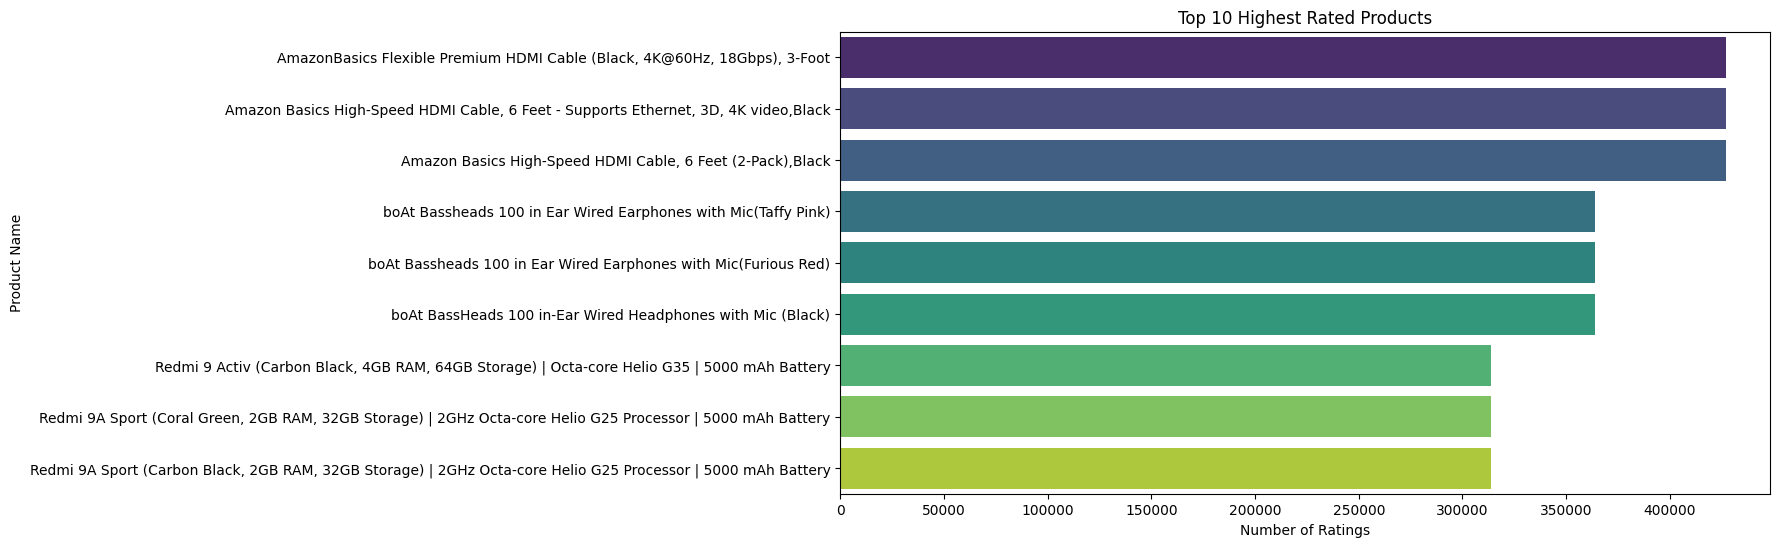

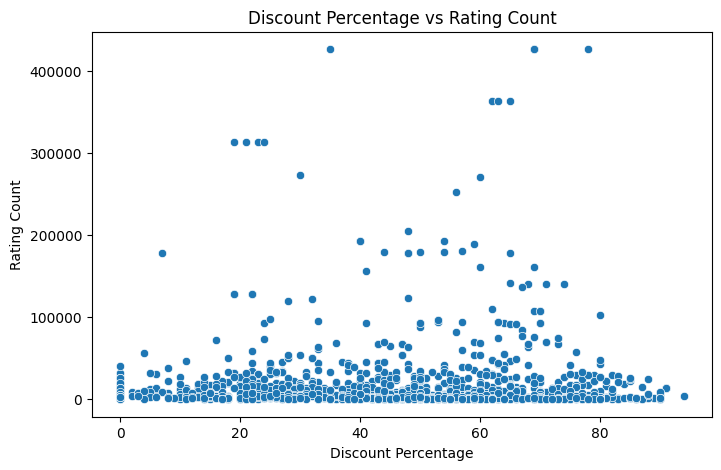

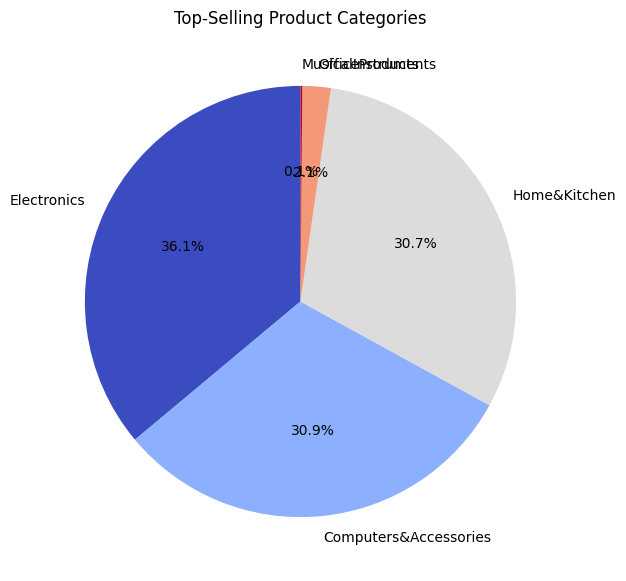

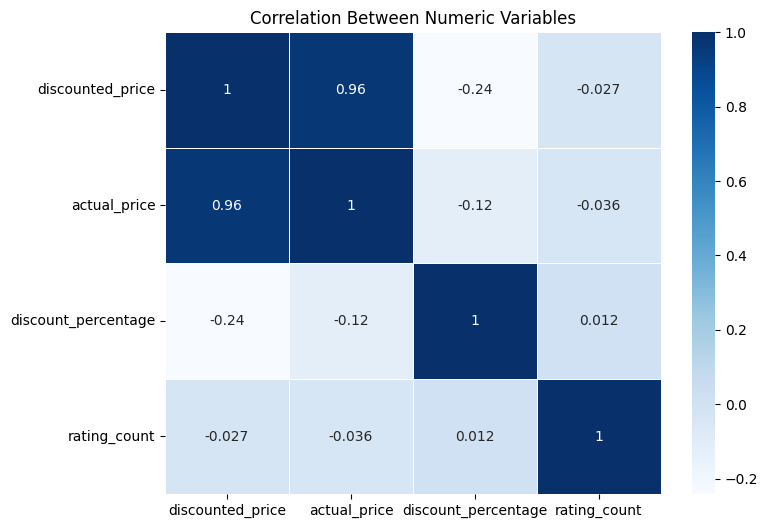


📊 Business Insights:
- Categories with high discounts and high ratings should be prioritized.
- Products with high ratings and low discounts may still perform well.
- The top-selling categories should be focused on for new product launches.
- Further analysis can be done to identify seasonal trends.


In [6]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1️⃣ Load & Inspect Dataset
# ----------------------------
df = pd.read_csv("amazon.csv")

# Display first few rows
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Remove missing values (or handle them differently if needed)
df.dropna(inplace=True)

# ----------------------------
# 2️⃣ Data Cleaning
# ----------------------------
# Convert price columns to numeric (removing ₹ and commas)
df['discounted_price'] = df['discounted_price'].replace('[₹,]', '', regex=True).astype(float)
df['actual_price'] = df['actual_price'].replace('[₹,]', '', regex=True).astype(float)

# Convert rating_count to integer
df['rating_count'] = df['rating_count'].replace(',', '', regex=True).astype(int)

# Extract product categories (first category from 'category' column)
df['category'] = df['category'].apply(lambda x: x.split('|')[0] if isinstance(x, str) else "Unknown")

# Compute discount amount
df['discount_amount'] = df['actual_price'] - df['discounted_price']

# Convert discount_percentage to numeric
df['discount_percentage'] = df['discount_percentage'].replace('%', '', regex=True).astype(float)

# ----------------------------
# 3️⃣ MySQL Database Integration
# ----------------------------
# Connect to MySQL Server
conn = mysql.connector.connect(
    # host="localhost",
    # user="root",
    # password="Test@2025"  # Replace with your actual password


    host="localhost",
    user="root",
    password="Test@2025",
    database="ecommerce_db"
)
cursor = conn.cursor()

# Create database
cursor.execute("CREATE DATABASE IF NOT EXISTS ecommerce_db")
cursor.execute("USE ecommerce_db")

# Create table for products
cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
    id INT AUTO_INCREMENT PRIMARY KEY,
    product_name VARCHAR(255),
    category VARCHAR(255),
    discounted_price FLOAT,
    actual_price FLOAT,
    discount_amount FLOAT,
    discount_percentage FLOAT,
    rating_count INT
)
""")

# Insert data into MySQL (avoid duplicates)
for _, row in df.iterrows():
    cursor.execute("""
    REPLACE INTO products (product_name, category, discounted_price, actual_price, discount_amount, discount_percentage, rating_count)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    """, (row['product_name'], row['category'], row['discounted_price'], row['actual_price'], row['discount_amount'], row['discount_percentage'], row['rating_count'],)
    )

conn.commit()

# ----------------------------
# 4️⃣ SQL Queries for Analysis
# ----------------------------
# Retrieve top 10 most reviewed products
cursor.execute("SELECT product_name, rating_count FROM products ORDER BY rating_count DESC LIMIT 10")
top_reviewed = cursor.fetchall()
print("\nTop 10 Most Reviewed Products:")
for row in top_reviewed:
    print(row)

# Find the category with the highest average rating
cursor.execute("""
SELECT category, AVG(rating_count) as avg_rating
FROM products GROUP BY category ORDER BY avg_rating DESC LIMIT 1
""")
print("\nCategory with Highest Average Rating:", cursor.fetchone())

# Identify products with a discount greater than 50%
cursor.execute("SELECT product_name, discount_percentage FROM products WHERE discount_percentage > 50")
print("\nProducts with >50% Discount:", cursor.fetchall())

# List top 5 best-selling categories
cursor.execute("""
SELECT category, COUNT(*) AS total_reviews
FROM products GROUP BY category ORDER BY total_reviews DESC LIMIT 5
""")
print("\nTop 5 Best-Selling Categories:", cursor.fetchall())

# ----------------------------
# 5️⃣ Exploratory Data Analysis (EDA)
# ----------------------------
plt.figure(figsize=(10,5))
sns.histplot(df['rating_count'], bins=30, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Ratings Count")
plt.ylabel("Frequency")
plt.show()

# Correlation between discount percentage and rating count
correlation = df[['discount_percentage', 'rating_count']].corr()
print("\nCorrelation Between Discount Percentage & Rating Count:\n", correlation)

# ----------------------------
# 6️⃣ Data Visualization
# ----------------------------

# Top 10 highest-rated products
top_rated = df.nlargest(10, 'rating_count')
plt.figure(figsize=(12,6))
sns.barplot(y=top_rated['product_name'], x=top_rated['rating_count'], palette="viridis")
plt.xlabel("Number of Ratings")
plt.ylabel("Product Name")
plt.title("Top 10 Highest Rated Products")
plt.show()

# Scatter plot: Discount Percentage vs Rating Count
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['discount_percentage'], y=df['rating_count'])
plt.xlabel("Discount Percentage")
plt.ylabel("Rating Count")
plt.title("Discount Percentage vs Rating Count")
plt.show()

# Pie chart: Top 5 best-selling categories
top_categories = df['category'].value_counts().nlargest(5)
plt.figure(figsize=(7,7))
top_categories.plot.pie(autopct="%1.1f%%", cmap="coolwarm", startangle=90)
plt.title("Top-Selling Product Categories")
plt.ylabel("")
plt.show()

# Heatmap showing correlation between numerical columns
plt.figure(figsize=(8,6))
sns.heatmap(df[['discounted_price', 'actual_price', 'discount_percentage', 'rating_count']].corr(), annot=True, cmap="Blues", linewidths=0.5)
plt.title("Correlation Between Numeric Variables")
plt.show()

# ----------------------------
# 7️⃣ Business Insights & Conclusion
# ----------------------------
print("\n📊 Business Insights:")
print("- Categories with high discounts and high ratings should be prioritized.")
print("- Products with high ratings and low discounts may still perform well.")
print("- The top-selling categories should be focused on for new product launches.")
print("- Further analysis can be done to identify seasonal trends.")

# Close database connection
cursor.close()
conn.close()
